# Comparing SODA an WOA TS diagrams
for model validation

# <span style='color:Green'> SODA 3.4.2

In [3]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [4]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.b76e42daa6e24f3f81aff9824259a545/status,


In [50]:
client.close()
cluster.close()

In [5]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import gsw
from xhistogram.xarray import histogram
import fastjmd95 
from fastjmd95 import jmd95numba
import json

In [27]:
#soda file was saved in this nb 
woa = xr.open_dataarray('/home/jovyan/chapter1/WOA/ts_hist_0512.nc')
soda = xr.open_dataarray('/home/jovyan/chapter1/SODA/ts_hist_mean_SODA.nc')

In [6]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

cells = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SODA/cells_wg.zarr'))

In [7]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem(requester_pays=True)
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True)#, decode_times=False)

In [8]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

In [9]:
#WG boundaries (80˚S, 57˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 208 #right exclusive so it'll stop at -57.225204
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 208 #-57.15741334
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [10]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_top = dict(grid_y_T=slice(lower_lat, upper_lat))
lon_range_top = dict(grid_x_T=slice(left_lon, right_lon))

In [11]:
ds_wg = ocean.isel(**lat_range, **lon_range)

In [12]:
#have to give the 2 endpts same date for avging to work and keep the 12-24 timestamp
salt19 = ds_wg.salt.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
salt29 = ds_wg.salt.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

temp19 = ds_wg.temp.sel(time='2018-12-19').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})
temp29 = ds_wg.temp.sel(time='2018-12-29').to_dataset().assign_coords({'time':ds_wg.time.sel(time='2018-12-24')})

salt25 = ds_wg.salt.sel(time='1993-12-25').to_dataset().assign_coords({'time':ds_wg.time.sel(time='1993-12-30')})
salt04 = ds_wg.salt.sel(time='1994-01-04').to_dataset().assign_coords({'time':ds_wg.time.sel(time='1993-12-30')})

In [13]:
#avging the two endpts to insert onto 12-24 date instead of it being 0 (will help solve spike in timeseries)
salt24_ds = (salt19+salt29)/2
salt24 = salt24_ds.salt

temp24_ds = (temp19+temp29)/2
temp24 = temp24_ds.temp

#avging the two endpts to insert onto 1993-12-30 since there is a spike on that date due to nudging
salt30_ds = (salt25+salt04)/2
salt30 = salt30_ds.salt

In [14]:
#inserting avged salt/temp values on 12-24 date into ds_wg
ds_wg['salt'][1897] = salt24[0]
ds_wg['temp'][1897] = temp24[0]

#inserting avged salt value on 1993-12-30 date into ds_wg
ds_wg['salt'][72] = salt30[0]

In [15]:
#adjusting for another spike in jan1997

#going to insert avg'd values from dec & feb into jan
dec = ds_wg.salt.sel(time='1996-12')
jan = ds_wg.salt.sel(time='1997-01')
feb = ds_wg.salt.sel(time='1997-02')

#creating new jan object with avg'd values from prev and next months
for i in range(6):
    jan[i] = ((dec[i] + feb[i]) / 2)
    
jan_range = np.arange(292, 298)

#plugging new jan values into ds_wg
for i in range(6):
    for j in jan_range:
        ds_wg.salt[j] = jan[i]

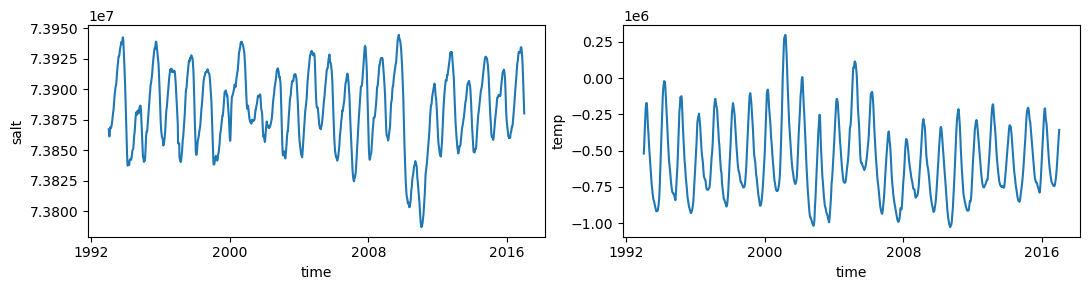

In [16]:
#success! no more spikes
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(11,3))
ds_wg.salt.sel(time=slice('1993', '2016')).sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax0)
ds_wg.temp.sel(time=slice('1993', '2016')).sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot(ax=ax1)
plt.tight_layout();

In [17]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.b76e42daa6e24f3f81aff9824259a545/status,


In [18]:
mask = ((ds_wg.temp < -0.001) | (ds_wg.temp > 0)).isel(time=9).compute()

In [19]:
salt_bins = np.linspace(31, 35, 100)
theta_bins = np.linspace(-2.5, 8, 100)
delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

vol = cells.dx_interp * cells.dy_u * cells.dz

In [20]:
ts_hist = histogram(ds_wg.temp.where(mask), ds_wg.salt, 
                    bins=[theta_bins, salt_bins],
                    weights=vol, 
                    dim=['xt_ocean', 'yt_ocean', 'st_ocean']).rename({'temp_bin':'theta_bin', 
                                                                      'salt_bin':'salt_bin'}) / (delta_salt * delta_theta)
ts_hist.load()

/tmp/ipykernel_2829/510876666.py:1: UserWarning: rename 'salt_bin' to 'salt_bin' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ts_hist = histogram(ds_wg.temp.where(mask), ds_wg.salt,


<xarray.DataArray 'histogram_temp_salt' (time: 1970, theta_bin: 99, salt_bin: 99)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * time       (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [21]:
#taking hist mean over `time` takes average (notice the scales are diff in either plots)
ts_hist_mean = ts_hist.sel(time=slice('2005','2012')).mean(dim='time')

In [22]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.b76e42daa6e24f3f81aff9824259a545/status,


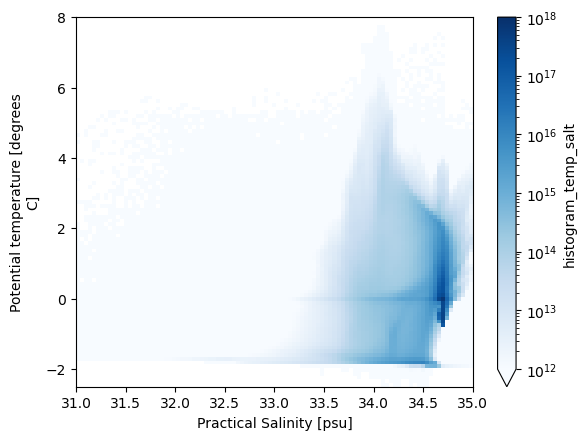

In [23]:
ts_hist_mean.plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18)

In [24]:
ts_hist_mean.to_netcdf('ts_hist_mean_SODA.nc', mode='w')

# <span style='background :yellow'> Difference between SODA and WOA (2005-2012) </span>

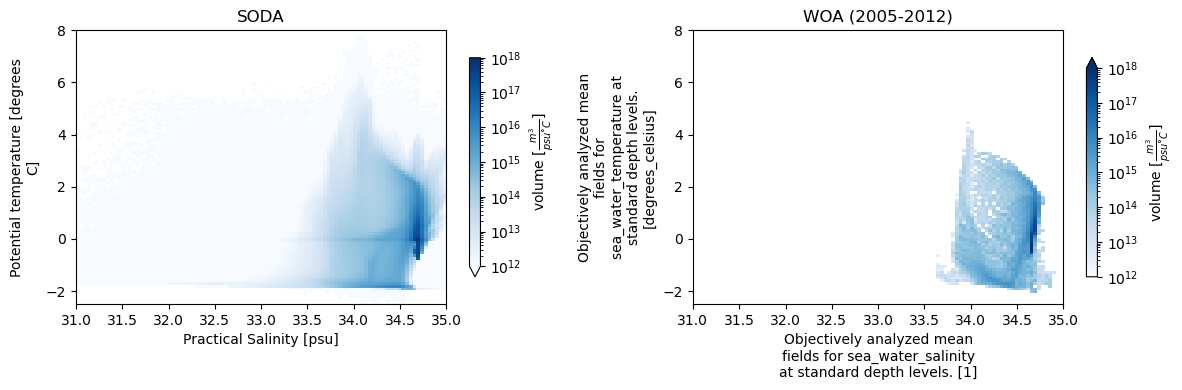

In [31]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

soda.where(soda>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax0)
ax0.set_title('SODA')

woa.where(woa>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'}, ax=ax1)
ax1.set_title('WOA (2005-2012)')

plt.tight_layout();

In [32]:
diff_soda_woa0512 = soda - woa
diff_soda_woa0512

<xarray.DataArray (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98

In [34]:
sigma2 = jmd95numba.rho(diff_soda_woa0512.salt_bin, diff_soda_woa0512.theta_bin, 2000.)

In [35]:
sigma2

<xarray.DataArray 'salt_bin' (salt_bin: 99, theta_bin: 99)>
array([[1034.48446211, 1034.47686275, 1034.46911858, ..., 1033.15615741,
        1033.13654091, 1033.116816  ],
       [1034.51665196, 1034.50903907, 1034.50128143, ..., 1033.18726956,
        1033.1676439 , 1033.14790986],
       [1034.5488422 , 1034.54121579, 1034.53344467, ..., 1033.21838227,
        1033.19874744, 1033.17900428],
       ...,
       [1037.57657459, 1037.56768554, 1037.55865689, ..., 1036.14555665,
        1036.12506696, 1036.10447236],
       [1037.60880537, 1037.59990298, 1037.59086104, ..., 1036.17672527,
        1036.15622655, 1036.13562296],
       [1037.64103662, 1037.63212089, 1037.62306566, ..., 1036.2078945 ,
        1036.18738676, 1036.16677418]])
Coordinates:
  * salt_bin   (salt_bin) float64 31.02 31.06 31.1 31.14 ... 34.9 34.94 34.98
  * theta_bin  (theta_bin) float64 -2.447 -2.341 -2.235 ... 7.735 7.841 7.947
Attributes:
    cell_methods:   time: mean
    coordinates:    geolon_t geolat_t
    long_name:      Practical Salinity
    standard_name:  sea_water_salinity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          psu
    valid_range:    [-10. 100.]

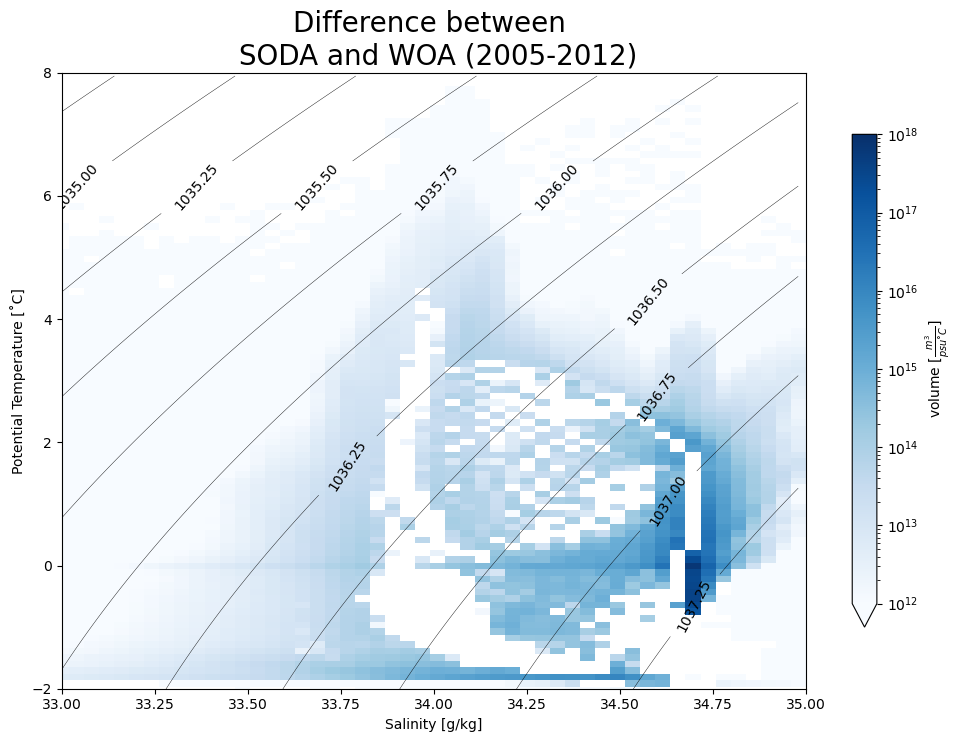

In [36]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa0512.where(diff_soda_woa0512>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [g/kg]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Difference between \n SODA and WOA (2005-2012)', fontsize=20);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 8);

## <span style='color:Purple'> Linear Scale

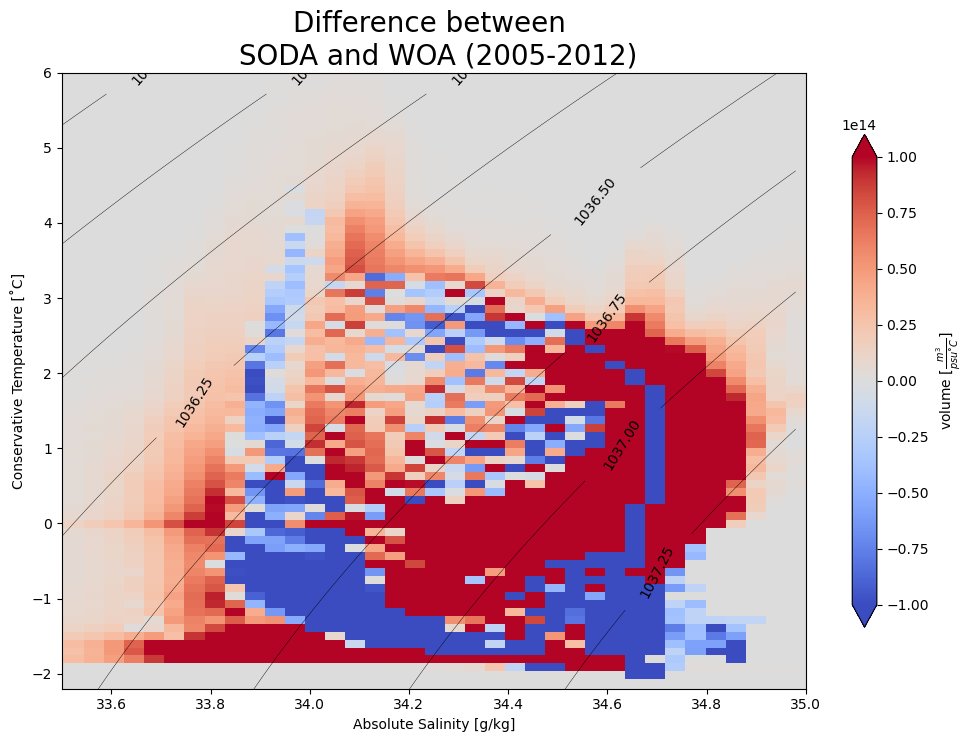

In [37]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa0512.plot(cmap='coolwarm', vmax=1e14,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Difference between \n SODA and WOA (2005-2012)', fontsize=20);
ax.set_xlim(33.5, 35)
ax.set_ylim(-2.2, 6);

## <span style='color:Purple'> Semi-Log Scale
using `SymLogNorm()` --> have to specify `linthresh` parameter - below this absolute value the colormap is linear, and outside the ± bounds cmap is logarithmic.

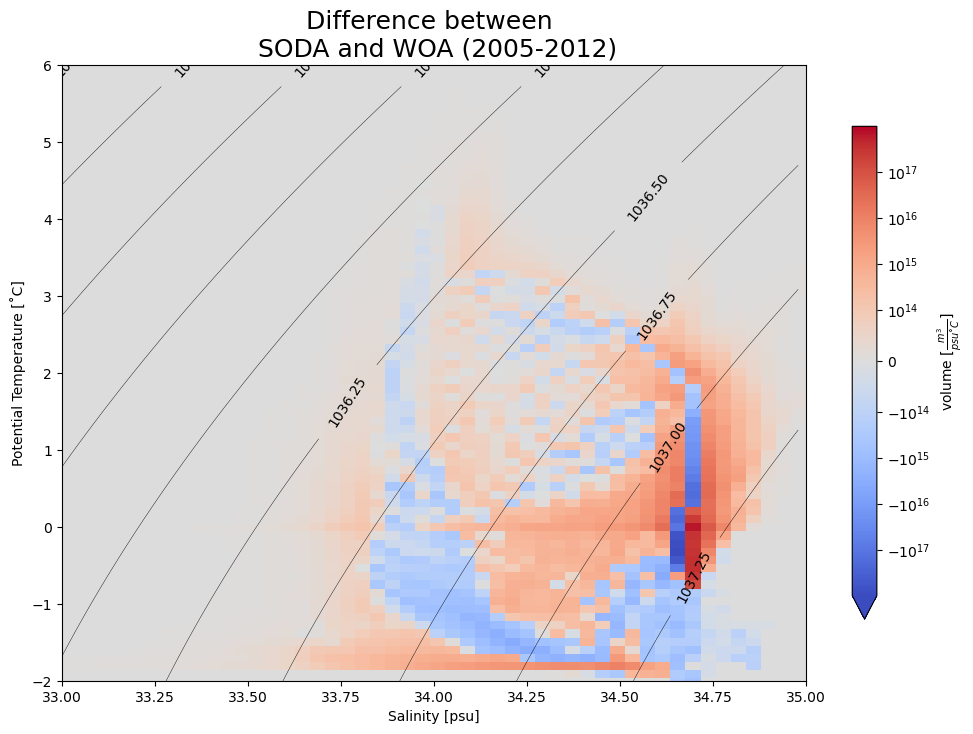

In [38]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
diff_soda_woa0512.plot(norm=SymLogNorm(linthresh=1e14), cmap='coolwarm', vmax=1e18,
                                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

ax.set_xlabel('Salinity [psu]')
ax.set_ylabel('Potential Temperature [˚C]')
ax.set_title('Difference between \n SODA and WOA (2005-2012)', fontsize=18);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 6);

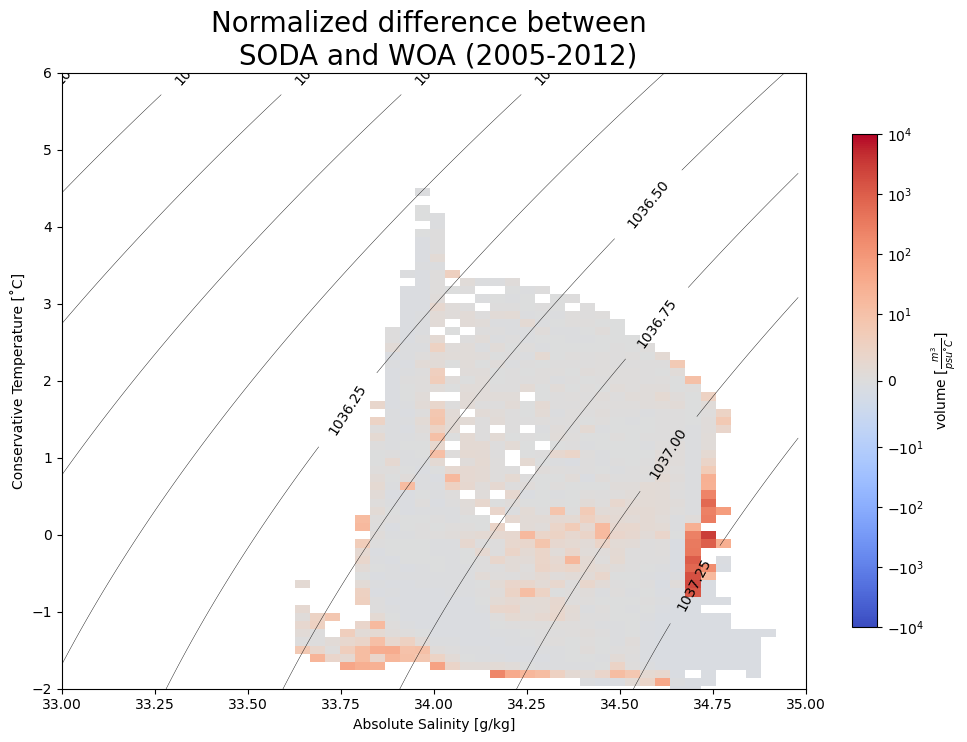

In [39]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sigma_levs = np.arange(1032, 1037.5, 0.25)

C = sigma2.T.plot.contour(colors='k', linewidths=0.3, levels=sigma_levs, ax=ax)
plt.clabel(C)
(diff_soda_woa0512/woa).plot(norm=SymLogNorm(linthresh=10), cmap='coolwarm', vmax=1e4,
                                  cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})
#got 0.4e18 from Linear Scale plot
#blue is positive
#red is negative

ax.set_xlabel('Absolute Salinity [g/kg]')
ax.set_ylabel('Conservative Temperature [˚C]')
ax.set_title('Normalized difference between \n SODA and WOA (2005-2012)', fontsize=20);
ax.set_xlim(33, 35)
ax.set_ylim(-2, 6);

## Gade Line

$$
T_P(S_P) = T_{ocean} + \frac{L_F}{C_P}(1 - \frac{S_{ocean}}{S_P})
$$
where $L_F = 334$ kJ kg$^-1$ (Latent heat of fusion for ice); and $C_P = 3.9$ kJ kg$^-1$ K$^-1$ (specific heat of water)

> Characteristic $T_{ocean}$ and $S_{ocean}$ for AABW is -0.7 ˚C and 34.6 psu

In [40]:
def gade_line(model):
    """Creating function to comput the Gade line for each model"""
    Tocean = -0.7
    Socean = 34.6
    LF = 334
    CP = 3.9
    #TP = model.theta_bin
    SP = model.salt_bin
    
    TP = Tocean + (LF / CP)*(1 - (Socean / SP))
    
    return(TP)

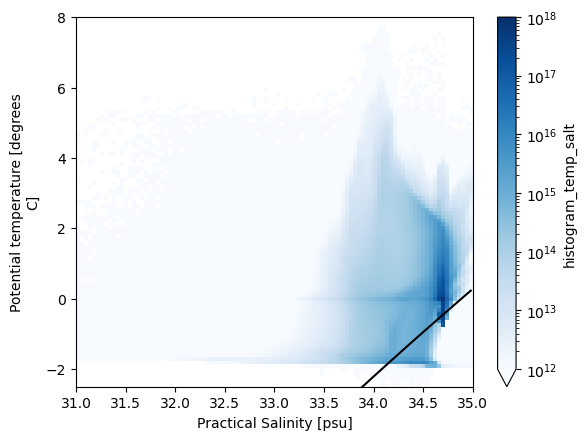

In [41]:
fig, ax = plt.subplots()

gade_line(ts_hist_mean).plot(ax=ax, color='k')
ts_hist_mean.where(ts_hist_mean>0).plot(norm=LogNorm(), cmap='Blues', vmin=1e12, vmax=1e18, ax=ax)

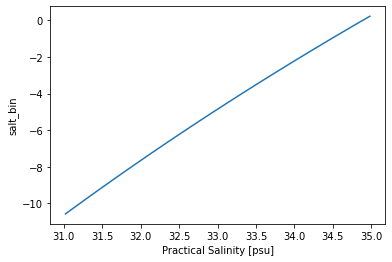

In [21]:
gade_line(ts_hist).plot()